In [118]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, invgamma
from scipy.special import gamma
from scipy.special import loggamma
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
import logging
from collections import Counter
import time 

In [2]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

In [726]:
# hyperparameter 
GROUP_NUM = 5
GROUP_NAME = ["A", "B", "C", "D", "E"]
INGROUP_NUM = 10
mus = {GROUP_NAME[idx]: val for idx, val in enumerate(np.random.uniform(0, 2, 2 * GROUP_NUM).reshape(-1, 2))}
A = np.random.uniform(5, 10, (GROUP_NUM, 2, 2))
sigma_matrixs = []
for A in np.random.rand(GROUP_NUM, 2, 2):
    sigma_matrixs.append(A.T @ A)
sigma_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate(sigma_matrixs)}

vs = {GROUP_NAME[idx]: val for idx, val in enumerate(np.random.uniform(4, 5, GROUP_NUM))}
ss = {GROUP_NAME[idx]: val for idx, val in enumerate(np.random.uniform(1/3, 1/2, GROUP_NUM))}

# grid points
GRID_NUM = 100
X_tilde = [[np.concatenate((np.ones((GRID_NUM, 1)), np.linspace(0, 2, GRID_NUM).reshape(-1, 1)), axis=1).tolist()] * INGROUP_NUM]
Xs_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(X_tilde * GROUP_NUM))}
lambda_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate([np.eye(2)] * GROUP_NUM)}
weight_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array([[np.eye(GRID_NUM)] * INGROUP_NUM] * GROUP_NUM))}
# print(np.all(np.linalg.eigvals(sigma_matrixs) > 0))

# prior
sigmas = []
for v, s in zip(vs.values(), ss.values()):
    sigmas.append(invgamma.rvs(a=v / 2, scale=10 * s / 2, size=INGROUP_NUM))
sigmas = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigmas))}

betas = []
for mu, sigma_all, sigma_matrix, lambda_matrix in \
    zip(mus.values(), sigmas.values(), sigma_matrixs.values(), lambda_matrixs.values()):
    beta = []
    for sigma in sigma_all:
        beta.append(multivariate_normal.rvs(mu, sigma * np.linalg.inv(lambda_matrix) @ np.linalg.inv(sigma_matrix)))
    betas.append(np.array(beta))
betas = {GROUP_NAME[idx]: val for idx, val in enumerate(betas)}

# data
ys_tilde = []
for beta_all, sigma_all, weight_matrix_all, X_tilde_all in \
    zip(betas.values(), sigmas.values(), weight_matrixs.values(), Xs_tilde.values()):
    y_tilde = []
    for beta, sigma, weight_matrix, X_tilde in zip(beta_all, sigma_all, weight_matrix_all, X_tilde_all):
        y_tilde.append(multivariate_normal.rvs(X_tilde @ beta, sigma * weight_matrix))
    ys_tilde.append(np.array(y_tilde))
ys_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(ys_tilde)}

In [115]:
# hyperparameter 
GROUP_NUM = 5
GROUP_NAME = ["A", "B", "C", "D", "E"]
INGROUP_NUM = 5
mus = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array([[5, 2]] * GROUP_NUM))}
A = np.random.uniform(5, 10, (GROUP_NUM, 2, 2))
sigma_matrixs = []
for A in np.random.rand(GROUP_NUM, 2, 2):
    # sigma_matrixs.append(A.T @ A)
    sigma_matrixs.append(np.eye(2))
sigma_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate(sigma_matrixs)}

vs = {GROUP_NAME[idx]: val for idx, val in enumerate([4] * GROUP_NUM)}
ss = {GROUP_NAME[idx]: val for idx, val in enumerate([1/2] * GROUP_NUM)}

# grid points
GRID_NUM = 200
X_tilde = [[np.concatenate((np.ones((GRID_NUM, 1)), np.linspace(0, 2, GRID_NUM).reshape(-1, 1)), axis=1).tolist()] * INGROUP_NUM]
Xs_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(X_tilde * GROUP_NUM))}
lambda_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate([np.eye(2)] * GROUP_NUM)}
weight_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array([[np.eye(GRID_NUM)] * INGROUP_NUM] * GROUP_NUM))}
# print(np.all(np.linalg.eigvals(sigma_matrixs) > 0))

# prior
sigmas = []
for v, s in zip(vs.values(), ss.values()):
    sigmas.append(invgamma.rvs(a=v / 2, scale=10 * s / 2, size=INGROUP_NUM))
sigmas = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigmas))}

betas = []
for mu, sigma_all, sigma_matrix, lambda_matrix in \
    zip(mus.values(), sigmas.values(), sigma_matrixs.values(), lambda_matrixs.values()):
    beta = []
    for sigma in sigma_all:
        beta.append(multivariate_normal.rvs(mu, sigma * np.linalg.inv(lambda_matrix) @ np.linalg.inv(sigma_matrix)))
    betas.append(np.array(beta))
betas = {GROUP_NAME[idx]: val for idx, val in enumerate(betas)}

# data
ys_tilde = []
for beta_all, sigma_all, weight_matrix_all, X_tilde_all in \
    zip(betas.values(), sigmas.values(), weight_matrixs.values(), Xs_tilde.values()):
    y_tilde = []
    for beta, sigma, weight_matrix, X_tilde in zip(beta_all, sigma_all, weight_matrix_all, X_tilde_all):
        y_tilde.append(multivariate_normal.rvs(X_tilde @ beta, sigma * weight_matrix))
    ys_tilde.append(np.array(y_tilde))
ys_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(ys_tilde)}

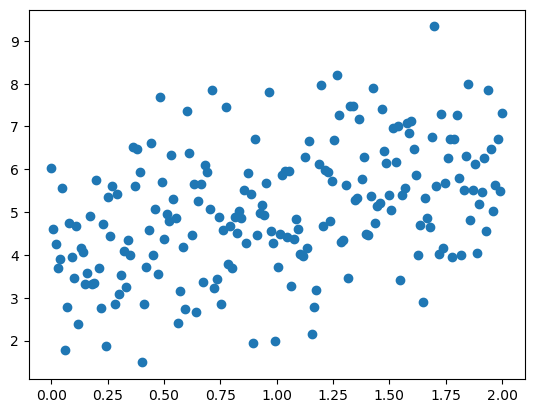

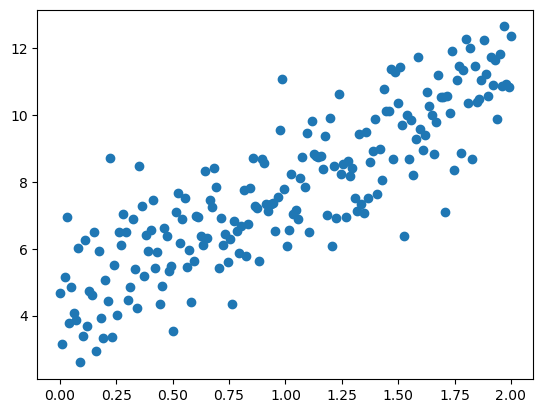

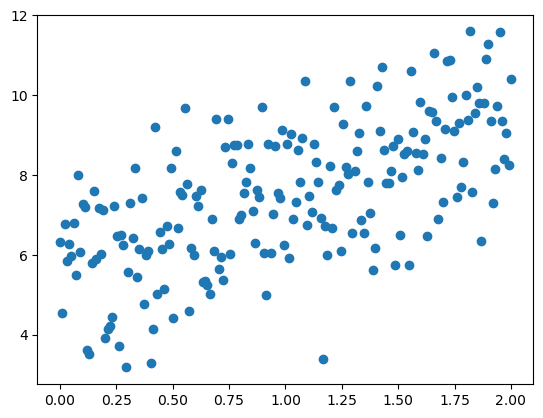

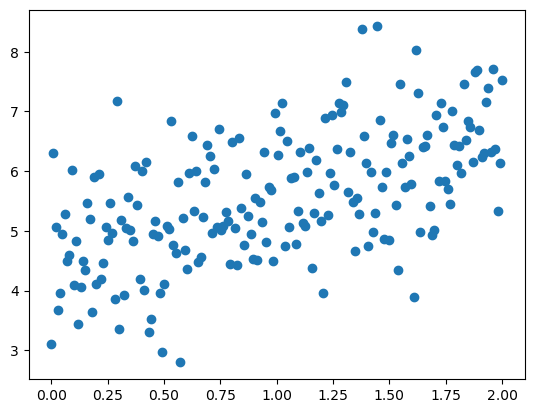

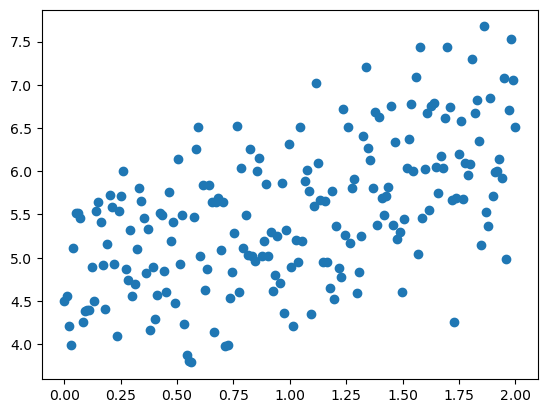

In [116]:
for i in range(5):
    plt.scatter(Xs_tilde["A"][i][:, 1], ys_tilde["A"][i])
    plt.show()

In [3]:
def caculate_mus_tilde(
        Xs_tilde,
        ys_tilde, 
        weight_matrixs, 
        lambda_matrixs, 
        sigma_matrixs, 
        mus
        ):
    mus_tilde = []
    for y_tilde_all, weight_matrix_all, lambda_matrix, sigma_matrix, mu, X_tilde_all in \
        zip(ys_tilde.values(), weight_matrixs.values(), lambda_matrixs.values(), \
            sigma_matrixs.values(), mus.values(), Xs_tilde.values()):
        mu_tilde = []
        for weight_matrix, X_tilde, y_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all):
            mu_tilde.append(np.linalg.inv(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ \
                            (X_tilde.T @ weight_matrix @ y_tilde + lambda_matrix @ sigma_matrix @ mu))
        mus_tilde.append(np.array(mu_tilde))
    return {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(mus_tilde))}

In [733]:
mus_tilde = caculate_mus_tilde(Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus)

In [4]:
def caculate_sigma_matrixs_tilde(
        Xs_tilde, 
        weight_matrixs, 
        lambda_matrixs, 
        sigma_matrixs
        ):
    sigma_matrixs_tilde = []
    for weight_matrix_all, lambda_matrix, sigma_matrix, X_tilde_all in \
        zip(weight_matrixs.values(), lambda_matrixs.values(), sigma_matrixs.values(), Xs_tilde.values()):
        sigma_matrix_tilde = []
        for weight_matrix, X_tilde in zip(weight_matrix_all, X_tilde_all):
            sigma_matrix_tilde.append(lambda_matrix @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))
        sigma_matrixs_tilde.append(np.array(sigma_matrix_tilde))
    return {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigma_matrixs_tilde))}

In [5]:
def caculate_as_tilde(vs, grid_num):
    return {GROUP_NAME[idx]: val for idx, val in enumerate(np.array([(v + grid_num) / 2 for v in vs.values()]))}

In [37]:
caculate_as_tilde(vs, 100)

{'A': 52.0, 'B': 52.0, 'C': 52.0, 'D': 52.0, 'E': 52.0}

In [6]:
def caculcate_bs_tilde(
        Xs_tilde,
        ys_tilde, 
        lambda_matrixs, 
        weight_matrixs, 
        sigma_matrixs, 
        vs, 
        ss, 
        mus_tilde, 
        mus
        ):
    
    bs_tilde = []
    for y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu_tilde_all, mu, X_tilde_all in \
        zip(ys_tilde.values(), lambda_matrixs.values(), weight_matrixs.values(), sigma_matrixs.values(), \
            vs.values(), ss.values(), mus_tilde.values(), mus.values(), Xs_tilde.values()):
        b_tilde = []
        for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
            b = v * s / 2
            first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
            second = y_tilde.T @ weight_matrix @ y_tilde
            last = mu.T @ lambda_matrix @ sigma_matrix @ mu
            b_tilde.append(b + 1 / 2 * (-first + second + last))
        bs_tilde.append(np.array(b_tilde))
    return {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(bs_tilde))}

In [7]:
def new_parameters(
        Xs_tilde, 
        ys_tilde, 
        weight_matrixs, 
        lambda_matrixs, 
        sigma_matrixs, 
        mus, 
        vs,
        ss, 
        grid_num
):
    mus_tilde = caculate_mus_tilde(Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus)
    sigma_matrixs_tilde = []
    bs_tilde = []
    as_tilde = []
    
    for y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu_tilde_all, mu, X_tilde_all in \
        zip(ys_tilde.values(), lambda_matrixs.values(), weight_matrixs.values(), sigma_matrixs.values(), \
            vs.values(), ss.values(), mus_tilde.values(), mus.values(), Xs_tilde.values()):
        sigma_matrix_tilde = []
        b_tilde = []
        for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
            
            sigma_matrix_tilde.append(lambda_matrix @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))

            b = v * s / 2
            first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
            second = y_tilde.T @ weight_matrix @ y_tilde
            last = mu.T @ lambda_matrix @ sigma_matrix @ mu
            b_tilde.append(b + 1 / 2 * (-first + second + last))

        sigma_matrixs_tilde.append(np.array(sigma_matrix_tilde))
        as_tilde.append([(v + grid_num) / 2] * INGROUP_NUM) 
        bs_tilde.append(np.array(b_tilde))
    
    sigma_matrix_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigma_matrixs_tilde))}
    a_tilde_all = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(as_tilde))}
    b_tilde_all = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(bs_tilde))}

    return mus_tilde, sigma_matrix_tilde, a_tilde_all, b_tilde_all



    # mus_tilde = caculate_mus_tilde(Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus)
    # sigma_matrixs_tilde = caculate_sigma_matrixs_tilde(Xs_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs)
    # as_tilde = caculate_as_tilde(vs, grid_num)
    # bs_tilde = caculcate_bs_tilde(Xs_tilde, ys_tilde, lambda_matrixs, weight_matrixs, sigma_matrixs, vs, ss, mus_tilde, mus)
    
    # return mus_tilde, sigma_matrixs_tilde, as_tilde, bs_tilde

In [38]:
mus_tilde, sigma_matrixs_tilde, as_tilde, bs_tilde = new_parameters(
    Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus, vs, ss, GRID_NUM)

In [8]:
def empirical_bayes(mus_tilde, as_tilde, bs_tilde):
    sigmas_empirical_bayes = []
    for a_tilde, b_tilde_all in zip(as_tilde.values(), bs_tilde.values()):
        sigma_empirical_bayes = []
        for b_tilde in b_tilde_all:
            sigma_empirical_bayes.append(b_tilde / (a_tilde - 1))
        sigmas_empirical_bayes.append(np.array(sigma_empirical_bayes))
    return mus_tilde, {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigmas_empirical_bayes))}

In [40]:
betas_tilde, sigmas_tilde = empirical_bayes(mus_tilde, as_tilde, bs_tilde)

In [783]:
# betas_tilde["A"], betas["A"]

In [784]:
# sigmas_tilde["A"], sigmas["A"]

In [9]:
def caculate_mu_mle(
        ys_tilde,
        lambda_matrixs,
        weight_matrixs,
        sigma_matrixs,
        vs,
        ss,
        mus,
        Xs_tilde,
        grid_num = 100, 
        ingroup_num = 5   
):
    mus_tilde = caculate_mus_tilde(Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus)
    sigma_matrixs_tilde_list = []
    bs_tilde_list = []
    as_tilde_list = []
    mus_mle_list = []

    for y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu_tilde_all, mu, X_tilde_all in \
        zip(ys_tilde.values(), lambda_matrixs.values(), weight_matrixs.values(), sigma_matrixs.values(), \
            vs.values(), ss.values(), mus_tilde.values(), mus.values(), Xs_tilde.values()):
        
        sigma_matrix_tilde_list = []
        b_tilde_list = []
        weight_list = []
        inverse_weight_list = []
        for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
            
            sigma_matrix_tilde_list.append(lambda_matrix @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))

            a_tilde = (v + grid_num) / 2

            b = v * s / 2
            first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
            second = y_tilde.T @ weight_matrix @ y_tilde
            last = mu.T @ lambda_matrix @ sigma_matrix @ mu
            b_tilde = b + 1 / 2 * (-first + second + last)
            b_tilde_list.append(b_tilde)

            A = np.linalg.inv(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix)
            weight = a_tilde / b_tilde * sigma_matrix @ lambda_matrix @ A @ X_tilde.T @ weight_matrix @ y_tilde
            inverse_weight = a_tilde / b_tilde * sigma_matrix @ lambda_matrix @ \
                                                    np.linalg.inv(np.eye(2) - A @ lambda_matrix @ sigma_matrix)
            weight_list.append(weight)
            inverse_weight_list.append(inverse_weight)

        sigma_matrixs_tilde_list.append(np.array(sigma_matrix_tilde_list))
        as_tilde_list.append([(v + grid_num) / 2] * ingroup_num) 
        bs_tilde_list.append(np.array(b_tilde_list))
        mus_mle_list.append(np.linalg.inv(sum(inverse_weight_list)) @ sum(weight_list))

    mus_mle = {GROUP_NAME[idx]: val for idx, val in enumerate(mus_mle_list)}
    sigma_matrixs_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigma_matrixs_tilde_list))}
    as_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(as_tilde_list))}
    bs_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(bs_tilde_list))}

    return mus_tilde, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde

In [1029]:
mus_tilde, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde = caculate_mu_mle(
    ys_tilde, lambda_matrixs, weight_matrixs, sigma_matrixs, vs, ss, mus, Xs_tilde
    )

In [10]:
def caculcate_bs_tilde_single(
        X_tilde_all,
        y_tilde_all, 
        lambda_matrix, 
        weight_matrix_all, 
        sigma_matrix, 
        v, 
        s, 
        mu_tilde_all, 
        mu, 
        name
        ):
    
    bs_tilde = []
    b_tilde = []
    for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
        b = v * s / 2
        first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
        second = y_tilde.T @ weight_matrix @ y_tilde
        last = mu.T @ lambda_matrix @ sigma_matrix @ mu
        b_tilde.append(b + 1 / 2 * (-first + second + last))
    bs_tilde.append(np.array(b_tilde))
    return {name: np.array(bs_tilde)}

In [272]:
name = "A"
caculcate_bs_tilde_single(Xs_tilde[name], ys_tilde[name], lambda_matrixs[name], weight_matrixs[name], sigma_matrixs[name], vs[name], ss[name], mus_tilde[name], mus[name], name)

In [11]:
def caculate_mus_tilde_single(
        X_tilde_all,
        y_tilde_all, 
        weight_matrix_all, 
        lambda_matrix, 
        sigma_matrix, 
        mu, 
        name
        ):
    mu_tilde = []
    for weight_matrix, X_tilde, y_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all):
        mu_tilde.append(np.linalg.inv(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ \
                        (X_tilde.T @ weight_matrix @ y_tilde + lambda_matrix @ sigma_matrix @ mu))
    return {name: np.array(mu_tilde)}

In [12]:
def caculate_mus_tilde_single(
        X_tilde_all,
        y_tilde_all, 
        weight_matrix_all, 
        lambda_matrix, 
        sigma_matrix, 
        mu, 
        name
        ):
    mu_tilde = []
    for weight_matrix, X_tilde, y_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all):
        mu_tilde.append(np.linalg.inv(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ \
                        (X_tilde.T @ weight_matrix @ y_tilde + lambda_matrix @ sigma_matrix @ mu))
    return {name: np.array(mu_tilde)}

In [1036]:
caculate_mus_tilde_single(
        Xs_tilde[name], ys_tilde[name],
        weight_matrixs[name], 
        lambda_matrixs[name], 
        sigma_matrixs[name], 
        mus[name], 
        "A"
        )

{'A': array([[4.98859008, 2.62275233],
        [6.09454424, 1.1810728 ],
        [5.78324216, 1.67808902],
        [3.8345363 , 2.84957121],
        [4.72066712, 1.87733472]])}

In [33]:
def caculate_mu_mle_single(
        X_tilde_all,
        y_tilde_all,
        weight_matrix_all,
        lambda_matrix,
        sigma_matrix,
        mu,
        v,
        s,
        name,
        grid_num, 
):
    mu_tilde_all = caculate_mus_tilde_single(X_tilde_all, y_tilde_all, weight_matrix_all, lambda_matrix, sigma_matrix, mu, name)[name]
    
    sigma_matrix_tilde_list = []
    a_tilde_list = []
    b_tilde_list = []
    weight_list = []
    inverse_weight_list = []
    for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
        
        sigma_matrix_tilde_list.append(lambda_matrix @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))

        a_tilde = (v + grid_num) / 2
        a_tilde_list.append(a_tilde)

        b = v * s / 2
        first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
        second = y_tilde.T @ weight_matrix @ y_tilde
        last = mu.T @ lambda_matrix @ sigma_matrix @ mu
        b_tilde = b + 1 / 2 * (-first + second + last)
        b_tilde_list.append(b_tilde)

        A = np.linalg.inv(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix)
        weight = a_tilde / b_tilde * sigma_matrix @ lambda_matrix @ A @ X_tilde.T @ weight_matrix @ y_tilde
        inverse_weight = a_tilde / b_tilde * sigma_matrix @ lambda_matrix @ \
                                                np.linalg.inv(np.eye(2) - A @ lambda_matrix @ sigma_matrix)
        weight_list.append(weight)
        inverse_weight_list.append(inverse_weight)


    mus_mle = {name: np.linalg.inv(sum(inverse_weight_list)) @ sum(weight_list)}
    sigma_matrixs_tilde = {name: np.array(sigma_matrix_tilde_list)}
    as_tilde = {name: np.array(a_tilde_list)}
    bs_tilde = {name: np.array(b_tilde_list)}

    return mu_tilde_all, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde

In [1006]:
GROUP_NAME = "A"

In [14]:
def caculate_mu_mle(
        Xs_tilde,
        ys_tilde,
        weight_matrixs,
        lambda_matrixs,
        sigma_matrixs,
        mus,
        vs,
        ss,
        grid_num,
        group_name
):
    mus_tilde_dict = {}
    mus_mle_dict = {}
    sigma_matrixs_tilde_dict = {}
    as_tilde_dict = {}
    bs_tilde_dict = {}

    for y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu, X_tilde_all, name in \
        zip(ys_tilde.values(), lambda_matrixs.values(), weight_matrixs.values(), sigma_matrixs.values(), \
            vs.values(), ss.values(), mus.values(), Xs_tilde.values(), group_name):
        
        mus_tilde_all, mus_mle_all, sigma_matrixs_tilde_all, as_tilde_all, bs_tilde_all = caculate_mu_mle_single(
            X_tilde_all, y_tilde_all, weight_matrix_all, lambda_matrix, sigma_matrix, mu, v, s, name, grid_num
            )
        
        mus_tilde_dict.update(mus_tilde_all)
        mus_mle_dict.update(mus_mle_all)
        sigma_matrixs_tilde_dict.update(sigma_matrixs_tilde_all)
        as_tilde_dict.update(as_tilde_all)
        bs_tilde_dict.update(bs_tilde_all)

    return mus_tilde_dict, mus_mle_dict, sigma_matrixs_tilde_dict, as_tilde_dict, bs_tilde_dict

In [47]:
mus_tilde, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde = caculate_mu_mle(
    Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus, vs, ss, grid_num = GRID_NUM,  
)

In [39]:
def negative_log_likelihood(
        v, 
        s, 
        sigma_matrix,
        Xs_tilde, 
        ys_tilde, 
        lambda_matrixs, 
        weight_matrixs, 
        mus,
        grid_num, 
        name
):
    ans = 0
    a1 = 0
    a2 = 0
    a3 = 0
    a4 = 0

    X_tilde_all, y_tilde_all, lambda_matrix, weight_matrix_all, mu =\
    Xs_tilde[name], ys_tilde[name], lambda_matrixs[name], weight_matrixs[name], mus[name]
    start = time.time()
    mu_tilde_all = caculate_mus_tilde_single(X_tilde_all, y_tilde_all, weight_matrix_all, lambda_matrix, sigma_matrix, mu, name)[name]
    end = time.time()
    print(end - start)
    start = time.time()
    b_tilde_all = caculcate_bs_tilde_single(X_tilde_all, y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu_tilde_all, mu, name)[name]
    end = time.time()
    print(end - start)
    for X_tilde, b_tilde, weight_matrix in zip(X_tilde_all, *b_tilde_all, weight_matrix_all):
        first = np.log(np.linalg.det(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))
        # second = np.log(np.linalg.det(weight_matrix))
        a = v / 2
        b = v * s / 2
        a_tilde = (v + grid_num) / 2

        third = a * np.log(b)
        forth = loggamma(a)
        fifth = loggamma(a_tilde)
        sixth = a_tilde * np.log(b_tilde)

        a1 += 1 / 2 * first
        a2 += third - forth
        a3 += fifth
        a4 += sixth

        ans += 1 / 2 * first + third - forth + fifth - sixth
    return -ans

In [63]:
name = "A"
negative_log_likelihood(vs[name], 
        ss[name], 
        sigma_matrixs[name],
        Xs_tilde, 
        ys_tilde, 
        lambda_matrixs, 
        weight_matrixs, 
        mus,
        grid_num=GRID_NUM
        name)

613.8262251584952

In [41]:
def estimator_negative_log_likelihood( 
        params, 
        Xs_tilde, 
        ys_tilde, 
        lambda_matrixs, 
        weight_matrixs, 
        mus, 
        grid_num,
        name
        ):
    
    sigma_matrix = np.diag(params[: 2])
    v = params[2]
    s = params[3]
    return negative_log_likelihood(v, s, sigma_matrix, Xs_tilde, ys_tilde, \
                                   lambda_matrixs, weight_matrixs, mus, grid_num, name)

In [65]:
estimator_negative_log_likelihood(        
    [1, 1, 1, 1], 
    Xs_tilde, 
    ys_tilde, 
    lambda_matrixs, 
    weight_matrixs, 
    mus, 
    name="A"
    )

614.2213248563273

In [66]:
objective_func = lambda params: estimator_negative_log_likelihood(        
    params, 
    Xs_tilde, 
    ys_tilde, 
    lambda_matrixs, 
    weight_matrixs,  
    mus, 
    name="A"
    )
res = minimize(objective_func, (2, 2, 1, 1), method='Nelder-Mead', bounds=((0, None), (0, None), (0, None), (0, None)))

In [67]:
res.x

array([0.00000000e+00, 1.88032119e-06, 6.05577607e+00, 1.07648320e+00])

In [17]:
def empirical_bayes_single(mu_tilde_all, as_tilde_all, bs_tilde_all):
    sigma_empirical_bayes = []
    for a_tilde, b_tilde in zip(*as_tilde_all.values(), *bs_tilde_all.values()):
        sigma_empirical_bayes.append(b_tilde / (a_tilde - 1))
    return mu_tilde_all, sigma_empirical_bayes

In [74]:
def weight(weight_matrix_all, X_tilde_all, y_tilde_all, betas_em, sigmas_em, alpha):
    for idx, elements in enumerate(zip(X_tilde_all, y_tilde_all, betas_em, sigmas_em)):
        X_tilde, y_tilde, beta_em, sigma_em = elements
        coeff = ((1 + alpha) / ((2 * np.pi )**(alpha / 2) * sigma_em**(alpha / 2 + 1)))
        exponential = np.exp(-(alpha / (2 * sigma_em)) * (y_tilde - X_tilde @ beta_em)**2)
        weight_matrix_all[idx] = np.diag(coeff * exponential)
    return weight_matrix_all

In [190]:
mus_initial = []
for X_tilde_all, y_tilde_all in zip(Xs_tilde.values(), ys_tilde.values()):
    mu_initial = []
    for X_tilde, y_tilde in zip(X_tilde_all, y_tilde_all):
        mu_initial.append(np.linalg.inv(X_tilde.T @ X_tilde) @ X_tilde.T @ y_tilde)
    mus_initial.append(np.mean(mu_initial, axis=0))
mus_initial = {GROUP_NAME[idx]: val for idx, val in enumerate(mus_initial)}

vs_initial = {GROUP_NAME[idx]: 2 for idx, _ in enumerate(mus_initial)}

ss_initial = []
for X_tilde_all, y_tilde_all, mu, v in zip(Xs_tilde.values(), ys_tilde.values(), mus_initial.values(), vs_initial.values()):
    s_initial = []
    for X_tilde, y_tilde in zip(X_tilde_all, y_tilde_all):
        s_initial.append((y_tilde - X_tilde @ mu).T @ (y_tilde - X_tilde @ mu) / v)
    ss_initial.append(np.mean(s_initial, axis=0))
ss_initial = {GROUP_NAME[idx]: val for idx, val in enumerate(ss_initial)}

sigma_matrixs_initial = {GROUP_NAME[idx]: val for idx, val in enumerate([np.eye(2)] * GROUP_NUM)}

In [118]:
mus_tilde, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde = caculate_mu_mle(
    Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs_initial, mus_initial, vs_initial, ss_initial, grid_num = GRID_NUM,  
)

In [119]:
mus_mle

{'A': array([4.48389567, 1.68122037]),
 'B': array([5.8209966 , 1.89461451]),
 'C': array([5.48455158, 2.28832774]),
 'D': array([4.43328599, 1.9063477 ]),
 'E': array([4.55101114, 1.76984722])}

In [137]:
losses = {}
for name in GROUP_NAME:
    loss = []
    for i in range(20):
        objective_func = lambda params: estimator_negative_log_likelihood(        
        params, Xs_tilde, ys_tilde, lambda_matrixs, weight_matrixs, mus_mle, name
        )
        res = minimize(objective_func, (1, 1, 1, 1), method='Nelder-Mead', bounds=((0.1, None), (0.1, None), (0, None), (0, None)))

        sigma_matrix = np.diag((res.x[:2]))
        v = res.x[2]
        s = res.x[3]
        
        mu_tilde_all, mu_mle, sigma_matrixs_tilde_all, as_tilde_all, bs_tilde_all = caculate_mu_mle_single(
            Xs_tilde[name], ys_tilde[name], weight_matrixs[name], lambda_matrixs[name], sigma_matrix, mus_initial[name], v, s, name, GRID_NUM
            )
        
        betas_em, sigmas_em = empirical_bayes_single(mu_tilde_all, as_tilde_all, bs_tilde_all)
        loss.append(sum((mu_mle[name] - mus[name]) ** 2))
        weight(weight_matrixs[name], Xs_tilde[name], ys_tilde[name], betas_em, sigmas_em, 0.1)
        
        print(mu_mle)
        print(sigma_matrix)
        print(v)
        print(s)
        print("-"*10)
        
    break

NameError: name 'GROUP_NAME' is not defined

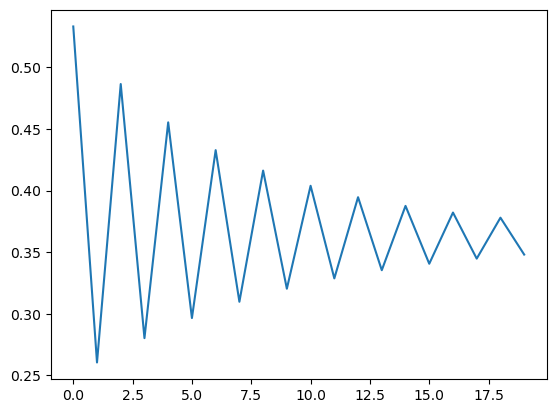

In [121]:
plt.plot(loss)

In [1165]:
weight(weight_matrixs[name], Xs_tilde[name], ys_tilde[name], betas_em, sigmas_em, 0.1)

array([1.27937104, 0.75833767, 1.26396106, 1.41264927, 0.99100045])

In [21]:
from QEB import QEB

In [61]:
qeb = QEB()
data = qeb.read_data(
    root_map='./dataset/emd_3488.map', 
    root_pdb='./dataset/5ni1.pdb',
    atomic="CA",
    max_rad = 0.8, 
    base_num_points=2, 
    max_points=10
    )

/Users/zhengshucheng/Desktop/中研院/QEB/QEB/utils.py:69: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_df = gb_defected.mean().reset_index()


  0%|          | 0/574 [00:00<?, ?it/s]

In [119]:
# increase ones
qeb.Xs_tilde = {}
for name in qeb.distances_to_center:
    X_tilde_new = []
    for distance_to_center in qeb.distances_to_center[name]:
        X_tilde_new.append(np.concatenate((np.ones_like(distance_to_center), distance_to_center)).reshape(2, -1).T)
    qeb.Xs_tilde[name] = np.array(X_tilde_new)

In [120]:
mus_initial = []
for X_tilde_all, y_tilde_all in zip(qeb.Xs_tilde.values(), qeb.data_log.values()):
    mu_initial = []
    for X_tilde, y_tilde in zip(X_tilde_all, y_tilde_all):
        mu_initial.append(np.linalg.inv(X_tilde.T @ X_tilde) @ X_tilde.T @ y_tilde)
    mus_initial.append(np.mean(mu_initial, axis=0))
mus_initial = {name: val for name, val in zip(qeb.data_log, mus_initial)}

In [121]:
vs_initial = {name: 2 for name in qeb.data_log}

In [122]:
ss_initial = []
for X_tilde_all, y_tilde_all, mu, v in zip(qeb.Xs_tilde.values(), qeb.data_log.values(), mus_initial.values(), vs_initial.values()):
    s_initial = []
    for X_tilde, y_tilde in zip(X_tilde_all, y_tilde_all):
        s_initial.append((y_tilde - X_tilde @ mu).T @ (y_tilde - X_tilde @ mu) / v)
    ss_initial.append(np.mean(s_initial, axis=0))
ss_initial = {name: val for name, val in zip(qeb.data_log, ss_initial)}

In [123]:
sigma_matrixs_initial = {name: val for name, val in zip(qeb.data_log, [np.eye(2)] * len(qeb.data_log))}

In [124]:
qeb.weight_matrixs = {}
for name in qeb.distances_to_center:
    weight_matrix_new = []
    for distance_to_center in qeb.distances_to_center[name]:
        weight_matrix_new.append(np.eye(len(distance_to_center)))
    qeb.weight_matrixs[name] = np.array(weight_matrix_new)

In [145]:
qeb.lambda_matrixs = {name: np.eye(2) for name in qeb.distances_to_center}

In [127]:
mus_tilde, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde = caculate_mu_mle(
    qeb.Xs_tilde, qeb.data_log, qeb.weight_matrixs, qeb.lambda_matrixs, sigma_matrixs_initial, mus_initial, vs_initial, ss_initial, grid_num=len(qeb.distances_to_center["VAL"]), group_name=list(qeb.distances_to_center)  
)

In [117]:
estimator_negative_log_likelihood((0, 0, 10, 10), qeb.Xs_tilde, qeb.data_log, qeb.lambda_matrixs, qeb.weight_matrixs, mus_mle, len(qeb.distances_to_center["VAL"][0]), "VAL")

41496.37134295603

In [135]:
start = time.time()
estimator_negative_log_likelihood((0, 0, 10, 10), qeb.Xs_tilde, qeb.data_log, qeb.lambda_matrixs, qeb.weight_matrixs, mus_mle, len(qeb.distances_to_center["VAL"][0]), "VAL")
end = time.time()
logging.info("Spending Time: " + str(round(end - start, 2))) 

INFO:root:Spending Time: 1.99


In [140]:
losses = {}
for name in list(qeb.distances_to_center):
    loss = []
    for i in range(5):
        objective_func = lambda params: estimator_negative_log_likelihood(        
        params, qeb.Xs_tilde, qeb.data_log, qeb.lambda_matrixs, qeb.weight_matrixs, mus_mle, len(qeb.distances_to_center["VAL"][0]), name
        )

        logging.info("Minimize res")
        start = time.time()
        res = minimize(objective_func, (1, 1, 1, 1), method='L-BFGS-B', bounds=((0.1, None), (0.1, None), (0, None), (0, None)))
        end = time.time()
        logging.info("Spending Time: " + str(round(end - start, 2)))

        sigma_matrix = np.diag((res.x[:2]))
        v = res.x[2]
        s = res.x[3]
        
        logging.info("Caculate mu mle")
        start = time.time()
        mu_tilde_all, mu_mle, sigma_matrixs_tilde_all, as_tilde_all, bs_tilde_all = caculate_mu_mle_single(
            qeb.Xs_tilde[name], qeb.data_log[name], qeb.weight_matrixs[name], qeb.lambda_matrixs[name], \
                sigma_matrix, mus_initial[name], v, s, name, len(qeb.distances_to_center[name])
            )
        end = time.time()
        logging.info("Spending Time: " + str(round(end - start, 2)))
        
        logging.info("Caculate Empirical Bayes")
        start = time.time()
        betas_em, sigmas_em = empirical_bayes_single(mu_tilde_all, as_tilde_all, bs_tilde_all)
        end = time.time()
        logging.info("Spending Time: " + str(round(end - start, 2)))
        # loss.append(sum((mu_mle[name] - mus[name]) ** 2))
        weight(qeb.weight_matrixs[name], qeb.Xs_tilde[name], qeb.data_log[name], betas_em, sigmas_em, 0.1)
        
        print(mu_mle)
        print(sigma_matrix)
        print(v)
        print(s)
        print("-"*10)
        
    break

INFO:root:Minimize res
INFO:root:Spending Time: 13.17
INFO:root:Caculate mu mle
INFO:root:Spending Time: 0.65
INFO:root:Caculate Empirical Bayes
INFO:root:Spending Time: 0.0
INFO:root:Minimize res


{'VAL': array([-1.16965364, -0.21461354])}
[[0.1 0. ]
 [0.  0.1]]
7.082707786827816
1.201017293768409
----------


/var/folders/jy/v3npq_7n4_3_w4y5qwm_rplm0000gn/T/ipykernel_75638/559123061.py:31: RuntimeWarning: divide by zero encountered in log
  third = a * np.log(b)
/var/folders/jy/v3npq_7n4_3_w4y5qwm_rplm0000gn/T/ipykernel_75638/559123061.py:31: RuntimeWarning: invalid value encountered in double_scalars
  third = a * np.log(b)
INFO:root:Spending Time: 3.84
INFO:root:Caculate mu mle
INFO:root:Spending Time: 0.3
INFO:root:Caculate Empirical Bayes
INFO:root:Spending Time: 0.0
INFO:root:Minimize res


{'VAL': array([-1.07999172, -0.35195709])}
[[1. 0.]
 [0. 1.]]
1.0
1.0
----------


INFO:root:Spending Time: 17.89
INFO:root:Caculate mu mle
INFO:root:Spending Time: 0.27
INFO:root:Caculate Empirical Bayes
INFO:root:Spending Time: 0.0
INFO:root:Minimize res


{'VAL': array([-1.17231085, -0.22647561])}
[[0.1 0. ]
 [0.  0.1]]
5.914351658258677
0.36356079161807264
----------


INFO:root:Spending Time: 2.3
INFO:root:Caculate mu mle
INFO:root:Spending Time: 0.25
INFO:root:Caculate Empirical Bayes
INFO:root:Spending Time: 0.0
INFO:root:Minimize res


{'VAL': array([-1.15753423, -0.26642485])}
[[0.5269705 0.       ]
 [0.        0.5269705]]
0.4744116687723633
0.4744116687723633
----------


/opt/anaconda3/envs/academia/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
INFO:root:Spending Time: 2.91
INFO:root:Caculate mu mle
INFO:root:Spending Time: 0.2
INFO:root:Caculate Empirical Bayes
INFO:root:Spending Time: 0.0


{'VAL': array([-1.17793971, -0.22752461])}
[[0.8553349 0.       ]
 [0.        0.8553349]]
1.9655604538991727
0.8392609983033952
----------


In [142]:
estimator_negative_log_likelihood(        
        res.x, qeb.Xs_tilde, qeb.data_log, qeb.lambda_matrixs, qeb.weight_matrixs, mus_mle, len(qeb.distances_to_center["VAL"][0]), name
        )

-108861.19994783048

In [141]:
negative_log_likelihood(res.x)

array([0.8553349 , 0.8553349 , 1.96556045, 0.839261  ])

In [ ]:
mean_densities = []
densities = qeb.data["VAL"][1]
start = 0
for distance, num in counter.items():
    mean_densities.append(densities[start: start + num].mean())


In [78]:
mus_mle

{'VAL': array([-1.20081558, -0.24040951]),
 'LEU': array([-1.20621803, -0.26480567]),
 'SER': array([-1.29033229, -0.33241996]),
 'PRO': array([-1.38884639, -0.23252046]),
 'ALA': array([-1.31057846, -0.29119336]),
 'ASP': array([-1.6194501 , -0.28331731]),
 'LYS': array([-1.38574362, -0.26675433]),
 'THR': array([-1.34726535, -0.24359179]),
 'ASN': array([-1.25887854, -0.25138568]),
 'TRP': array([-1.33096581, -0.20201584]),
 'GLY': array([-1.7412774 , -0.32781142]),
 'HIS': array([-1.49776097, -0.24609535]),
 'GLU': array([-1.50623785, -0.28905078]),
 'TYR': array([-1.17282216, -0.33392514]),
 'ARG': array([-1.11871877, -0.26994238]),
 'MET': array([-1.26410377, -0.27088934]),
 'PHE': array([-1.16932304, -0.26658228]),
 'GLN': array([-1.18524664, -0.22321175]),
 'CYS': array([-1.0554446 , -0.31945222])}

In [58]:
name = "VAL"
loss = []
for i in range(len(qeb.Xs_tilde[name])):
    loss.append(sum((qeb.Xs_tilde[name][i] @ mu_tilde_all[i] - qeb.data_log[name][i])**2))

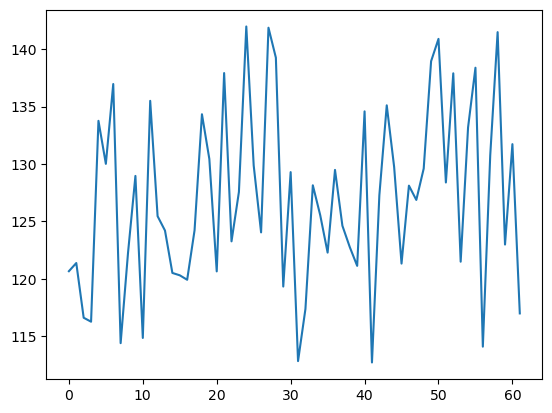

In [60]:
plt.plot(loss)

In [81]:
from QEB import *

In [83]:
interpolator(qeb.grid_points["VAL"][0])

TypeError: interpolator() missing 2 required positional arguments: 'grid_size' and 'origin'

In [102]:
counter = Counter(qeb.distances_to_center['VAL'][1])

In [103]:
mean_densities = []
densities = qeb.data["VAL"][1]
start = 0
for distance, num in counter.items():
    mean_densities.append(densities[start: start + num].mean())


In [109]:
qeb.data["VAL"][0]

array([0.15139048, 0.15159319, 0.15125777, 0.15153634, 0.15030747,
       0.1522626 , 0.15091308, 0.15113342, 0.15218273, 0.15103775,
       0.15119996, 0.15156229, 0.14984113, 0.15261233, 0.15062525,
       0.1509169 , 0.15271599, 0.15015505, 0.15223637, 0.1517547 ,
       0.1511676 , 0.15163552, 0.14933991, 0.15303996, 0.15040231,
       0.15078608, 0.15317261, 0.14976112, 0.15253804, 0.15190687,
       0.15113968, 0.15170562, 0.14883525, 0.15346668, 0.15018431,
       0.15065766, 0.15362547, 0.14936498, 0.1528385 , 0.15206332,
       0.15111618, 0.15177258, 0.14832718, 0.15389248, 0.14997125,
       0.15053166, 0.15407456, 0.1489666 , 0.15313775, 0.15222407,
       0.15109709, 0.15183638, 0.14781574, 0.15431737, 0.14976312,
       0.15040808, 0.15451986, 0.14856597, 0.15343583, 0.15238913,
       0.15108239, 0.15189703, 0.14730096, 0.15474138, 0.1495599 ,
       0.15028693, 0.15496134, 0.14816306, 0.15373276, 0.15255851,
       0.15107207, 0.15195452, 0.14678286, 0.15516449, 0.14936

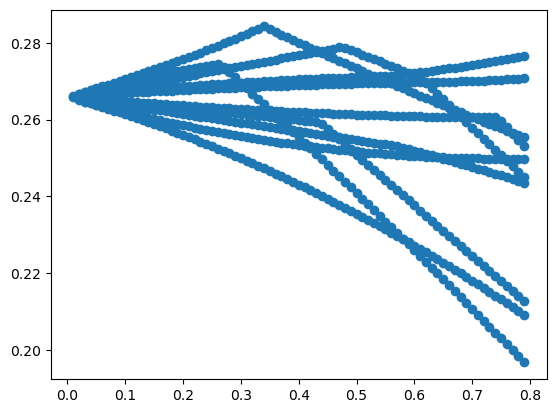

In [100]:
plt.scatter(qeb.distances_to_center["VAL"][1], qeb.data["VAL"][1])

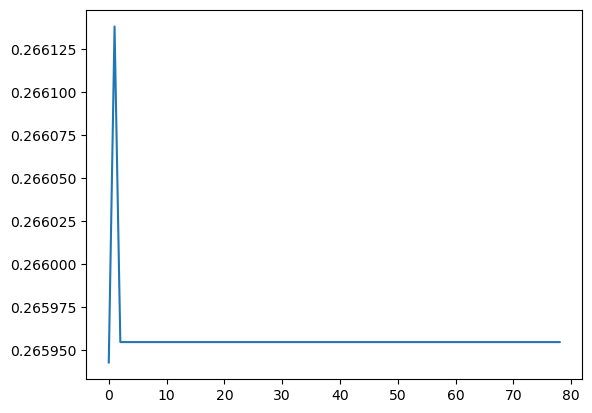

In [104]:
plt.plot(mean_densities)

In [106]:
mean_densities

[0.26594265984423626,
 0.26613821830596596,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.26595452618405624,
 0.2659545